In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from scipy.interpolate import interp1d

In [2]:
path=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\Testing\Matlab_H2O'

In [3]:
MI=pf.get_data(path=path, filename='03 BL1_MI1_H2O_quant.txt',
                  filetype='Witec_ASCII')
Ol=pf.get_data(path=path, filename='04 BL1_MI1_Ol_quant.txt',
                  filetype='Witec_ASCII')

# Trim to region of interest
x_min=800
x_max=900
Filt_Ol=Ol[~(
    (Ol[:, 0]<x_min) | 
    (Ol[:, 0]>x_max)
)]
Filt_MI=MI[~(
    (MI[:, 0]<x_min) | 
    (MI[:, 0]>x_max)
)]

# Fit spline to data

x_MI=Filt_MI[:, 0]
x_Ol=Filt_Ol[:, 0]

y_MI=Filt_MI[:, 1]
y_Ol=Filt_Ol[:, 1]


# Fit a  cubic spline
f2_MI = interp1d(x_MI, y_MI, kind='cubic')
f2_Ol = interp1d(x_Ol, y_Ol, kind='cubic')

x_new=np.linspace(min(x_Ol),max(x_Ol), 100000)

y_cub_MI=f2_MI(x_new)
y_cub_Ol=f2_Ol(x_new)

03 BL1_MI1_H2O_quant.txt
04 BL1_MI1_Ol_quant.txt


(500.0, 1500.0)

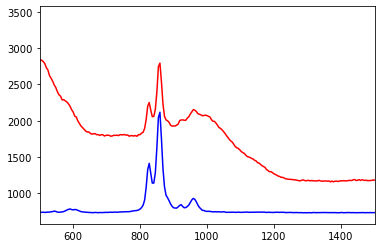

In [4]:
plt.plot(MI[:, 0], MI[:, 1], '-r')
plt.plot(Ol[:, 0], Ol[:, 1], '-b')
plt.xlim([500, 1500])

(700.0, 1100.0)

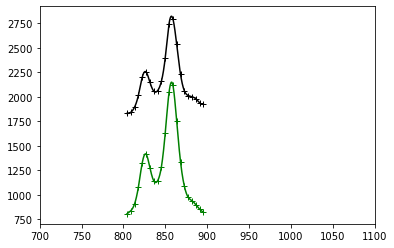

In [5]:
plt.plot(Filt_MI[:, 0], Filt_MI[:, 1], '+k')
plt.plot(Filt_Ol[:, 0], Filt_Ol[:, 1], '+g')
plt.plot(x_new, y_cub_MI, '-k')
plt.plot(x_new, y_cub_Ol, '-g')
plt.xlim([700, 1100])

# Options for algorithm
- Do an intergral after background subtraction, minimise area under peaks. Problem - Where do you put the background?
- Use Find peaks to find peaks in olivine, find those same peaks in the mixed spectra for different X. Differentiate around these points, if positive, still have a peak, if negative, have a trough. 

In [6]:
from scipy.signal import find_peaks
height=1
peaks_Ol = find_peaks(y_cub_Ol, height)
peak_height_Ol=peaks_Ol[1]['peak_heights']
peak_pos_Ol = x_new[peaks_Ol[0]]
peak_pos_Ol

array([826.39506985, 857.54945747])

In [7]:
trim_y_cub_Ol=y_cub_Ol[(x_new>(peak_pos_Ol[0]+3)) & (x_new<(peak_pos_Ol[1]-3))]
trim_x=x_new[(x_new>(peak_pos_Ol[0]+3)) & (x_new<(peak_pos_Ol[1]-3))]

max_trough_y=np.max(-trim_y_cub_Ol)
max_trough_x=trim_x[trim_y_cub_Ol==-max_trough_y]
max_trough_x

array([838.4866177])

In [8]:
spectra_x=x_new
peak_pos=peak_pos_Ol
spectra_y=y_cub_MI

peak1_x=peak_pos[0]
peak2_x=peak_pos[1]

peak1_y=spectra_y[spectra_x==peak1_x]
peak2_y=spectra_y[spectra_x==peak2_x]

In [9]:
peak1_y

array([2256.11849079])

In [10]:
## Lets write a function that fits a line through the peaks, 
# and sees if the trough is above or below
#Filt_MI
def trough_or_peak_higher(spectra_x, spectra_y, peak_pos_x, 
                          trough_pos_x, av_width=1, plot=False,
                         print=False):
    
    peak1_xex=peak_pos[0]
    peak2_xex=peak_pos[1]
    
    # Takes average av_width to either side of peak
    peak1_y=spectra_y[(spectra_x>peak1_xex-av_width)
                     &(spectra_x<peak1_xex+av_width)]
    peak2_y=spectra_y[(spectra_x>peak2_xex-av_width)
                     &(spectra_x<peak2_xex+av_width)]
    
    peak1_x=spectra_x[(spectra_x>peak1_xex-av_width)
                     &(spectra_x<peak1_xex+av_width)]
    peak2_x=spectra_x[(spectra_x>peak2_xex-av_width)
                     &(spectra_x<peak2_xex+av_width)]
    
    
    trough_y=spectra_y[(spectra_x>trough_pos_x-av_width)
                     &(spectra_x<trough_pos_x+av_width)]
    
    trough_x=spectra_x[(spectra_x>trough_pos_x-av_width)
                     &(spectra_x<trough_pos_x+av_width)]
    
    

    x=np.concatenate((peak1_x, peak2_x), axis=0)
    
    y=np.concatenate((peak1_y, peak2_y), axis=0)
    
    Px = np.linspace(peak1_x, peak2_x, 101)

    import scipy
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    Py=slope*Px+intercept
    Pred_trough=slope*np.nanmean(trough_x)+intercept
    
    if print is True:
        if np.nanmean(trough_y)>np.nanmean(Pred_trough):
            print('Trough higher than peaks, subtracted too much')

        if np.nanmean(trough_y)<np.nanmean(Pred_trough):
            print('Trough lower than peaks, not subtracted enough')
    Dist=np.nanmean(trough_y)-np.nanmean(Pred_trough)
    #Py=lr.predict(Px)
    if plot is True:
        plt.plot(peak1_x, peak1_y, '+m')
        plt.plot(peak2_x, peak2_y, '+m')
        plt.plot(trough_x, trough_y, '+g')

        plt.plot(Px, Py, '-r')
        plt.plot(trough_pos_x, Pred_trough, '*k', ms=10)
        plt.plot(spectra_x, spectra_y, '-k')
    return Dist
    

In [11]:
spectra_x=x_new
peak_pos=peak_pos_Ol
spectra_y=y_cub_MI

Dist=trough_or_peak_higher(spectra_x=x_new,
                      spectra_y=y_cub_MI,
                      peak_pos_x=peak_pos_Ol,
                      trough_pos_x=max_trough_x, av_width=2)
Dist

-417.09794227861676

0.7484848484848484

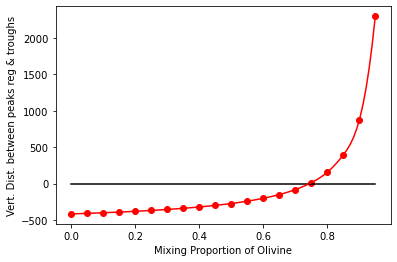

In [12]:
# Now lets mix up spectra
N_steps=20
MI_Mix=np.empty((N_steps,len(y_cub_MI)), 'float')
Dist=np.empty(N_steps, 'float')
X=np.empty(N_steps, 'float')
for i in range(0, N_steps):

    X[i]=i/N_steps

    MI_Mix[i, :]=(y_cub_MI- y_cub_Ol*X[i])/(1-X[i])
    Dist[i]=trough_or_peak_higher(spectra_x=x_new,
                      spectra_y=MI_Mix[i, :],
                      peak_pos_x=peak_pos_Ol,
                      trough_pos_x=max_trough_x, av_width=2)
    #print(MI_Mix)
plt.plot(X, Dist, 'or')
plt.plot([0, max(X)], [0, 0], '-k')
plt.xlabel('Mixing Proportion of Olivine')
plt.ylabel('Vert. Dist. between peaks reg & troughs')

mix_spline = interp1d(X, Dist, kind='cubic')

x_new_mix=np.linspace(min(X), max(X), 100)

y_cub_mix=mix_spline(x_new_mix)

plt.plot(x_new_mix, y_cub_mix, '-r')

# Closest point to zero
val=np.argmax(y_cub_mix>0)
ideal_mix=x_new_mix[val]
ideal_mix

# Best fit mix for olivine-glass

In [13]:
MI_Mix_Best_syn=(y_cub_MI- y_cub_Ol*ideal_mix)/(1-ideal_mix)
MI_Mix_Best=(MI- Ol*ideal_mix)/(1-ideal_mix)

(0.0, 1400.0)

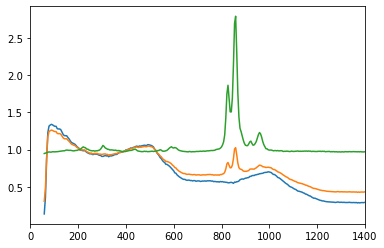

In [14]:
plt.plot(MI[:, 0],MI_Mix_Best[:, 1]/MI_Mix_Best[30, 1], '-')
plt.plot(MI[:, 0],MI[:, 1]/MI[30, 1], '-')
plt.plot(Ol[:, 0],Ol[:, 1]/Ol[30, 1], '-')
plt.xlim([0, 1400])

(600.0, 1400.0)

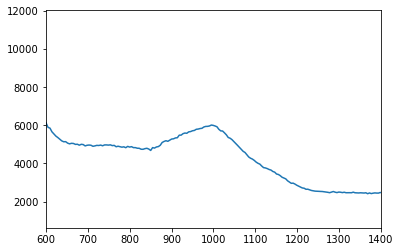

In [15]:
plt.plot(MI[:, 0],MI_Mix_Best[:, 1], '-')
plt.xlim([600, 1400])

## Water region background subtraction

## Silicate region background subtraction

,Sil_LHS_Back1,Sil_LHS_Back2,Sil_RHS_Back1,Sil_RHS_Back2,Sil_N_Poly,Sil_Trapezoid_Area,Sil_Simpson_Area
0,200,300,1240,1500,2,1.359518e+06,1.361283e+06


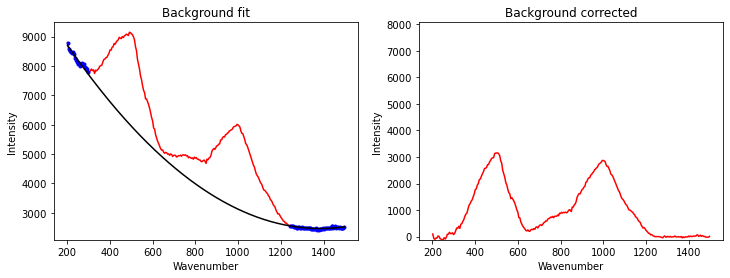

In [51]:
lower_range_sil=[200, 300] # MAtlab code uses 0-200, 
upper_range_sil=[1240, 1500] #1240-1500
sigma_sil=5
exclude_range1_sil=None
exclude_range2_sil=None
N_poly_sil=2
plot_figure=True
fit_sil='poly'

Sil=MI_Mix_Best

# These bits of code trim out the excluded regions if relevant
if exclude_range1_sil is not None and exclude_range2_sil is None:
    Sil_old=Sil.copy()
    Sil=Sil[(Sil[:, 0]<exclude_range1_sil[0])|(Sil[:, 0]>exclude_range1_sil[1])]
    Discard=Sil_old[(Sil_old[:, 0]>=exclude_range1_sil[0])
                    & (Sil_old[:, 0]<=exclude_range1_sil[1])]


if exclude_range2 is not None and exclude_range1 is None:
    Sil_old=Sil.copy()
    Sil=Sil[(Sil[:, 0]<exclude_range2_sil[0])|(Sil[:, 0]>exclude_range2_sil[1])]

    Discard=Sil_old[(Sil_old[:, 0]>=exclude_range2_sil[0]) 
                    & (Sil_old[:, 0]<=exclude_range2_sil[1])]

if exclude_range1 is not None and exclude_range2 is not None:
    Sil_old=Sil.copy()
    Sil=Sil[
    ((Sil[:, 0]<exclude_range1_sil[0])|(Sil[:, 0]>exclude_range1_sil[1]))
    &
    ((Sil[:, 0]<exclude_range2_sil[0])|(Sil[:, 0]>exclude_range2_sil[1]))
    ]

    Discard=Sil_old[
    ((Sil_old[:, 0]>=exclude_range1_sil[0]) & (Sil_old[:, 0]<=exclude_range1_sil[1]))
    |
    ((Sil_old[:, 0]>=exclude_range2_sil[0]) & (Sil_old[:, 0]<=exclude_range2_sil[1]))
    ]


# Now we calculate the edge of the baseline
lower_0baseline_sil=lower_range_sil[0]
upper_0baseline_sil=lower_range_sil[1]
lower_1baseline_sil=upper_range_sil[0]
upper_1baseline_sil=upper_range_sil[1]

# Bit that is actually peak, not baseline
span=[upper_0baseline_sil, lower_1baseline_sil]

# lower_2baseline=1320
# upper_2baseline=1330

# Trim for entire range
Sil_short=Sil[ (Sil[:,0]>lower_0baseline_sil) 
              & (Sil[:,0]<upper_1baseline_sil) ]

# Get actual baseline
Baseline_with_outl_sil=Sil_short[
((Sil_short[:, 0]<upper_0baseline_sil) &(Sil_short[:, 0]>lower_0baseline_sil))
     |
((Sil_short[:, 0]<upper_1baseline_sil) &(Sil_short[:, 0]>lower_1baseline_sil))]

# Calculates the median for the baseline and the standard deviation
Median_Baseline_sil=np.mean(Baseline_with_outl_sil[:, 1])
Std_Baseline_sil=np.std(Baseline_with_outl_sil[:, 1])

# Removes any points in the baseline outside of 2 sigma (helps remove cosmic rays etc).
Baseline_sil=Baseline_with_outl_sil[
(Baseline_with_outl_sil[:, 1]<Median_Baseline_sil+sigma_sil*Std_Baseline_sil)
                            &
(Baseline_with_outl_sil[:, 1]>Median_Baseline_sil-sigma_sil*Std_Baseline_sil)
                           ]


#Baseline=Baseline_with_outl


if fit_sil == 'poly':
    # Fits a polynomial to the baseline of degree
    Pf_baseline_sil = np.poly1d(np.polyfit(Baseline_sil[:, 0], Baseline_sil[:, 1], N_poly_sil))
    Py_base_sil =Pf_baseline_sil(Sil_short[:, 0])
    


    Baseline_ysub_sil=Pf_baseline_sil(Sil_short[:, 0])

    
if  fit_sil == 'spline':
    from scipy.interpolate import CubicSpline
    mix_spline_sil = CubicSpline(Baseline_sil[:, 0], Baseline_sil[:, 1],  
                            extrapolate=True)
    
    Baseline_ysub_sil=mix_spline_sil(Sil_short[:, 0]) 
    
    
    N_poly_sil='Spline'
    
Baseline_x_sil=Sil_short[:, 0]
y_corr_sil= Sil_short[:, 1]- Baseline_ysub_sil

x_sil=Baseline_sil[:, 0]

 # Plotting what its doing
if plot_figure is True:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.set_title('Background fit')
    ax1.plot(Sil_short[:, 0], Sil_short[:, 1], '-r')

    ax1.plot(Baseline_sil[:, 0], Baseline_sil[:, 1], '.b')
    ax1.plot(Sil_short[:, 0], Baseline_ysub_sil, '-k')
    xdat_sil=(Sil_short[:, 0])
    ydat_sil=y_corr_sil

    ax1.set_ylabel('Intensity')
    ax2.set_ylabel('Intensity')
    ax2.set_xlabel('Wavenumber')



    ax2.set_title('Background corrected')
    ax2.plot(xdat_sil, y_corr_sil, '-r')
    height_p=np.max(Sil_short[:, 1])-np.min(Sil_short[:, 1])
    ax2.set_ylim([np.min(y_corr), 1.2*height_p ])
    ax1.set_xlabel('Wavenumber')


from numpy import trapz
from scipy.integrate import simps
xspace_sil=xdat_sil[1]-xdat_sil[0]
area_trap = trapz(y_corr_sil, dx=xspace_sil)
area_simps = simps(y_corr_sil, dx=xspace_sil)



df_sil=pd.DataFrame(data={'Sil_LHS_Back1':lower_range_sil[0],
                      'Sil_LHS_Back2':lower_range_sil[1],
                      'Sil_RHS_Back1':upper_range_sil[0],
                      'Sil_RHS_Back2':upper_range_sil[1],
                      'Sil_N_Poly': N_poly_sil,
                      'Sil_Trapezoid_Area':area_trap,
                      'Sil_Simpson_Area': area_simps}, index=[0])
df_sil

## Same for H2O curve

,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly,Water_Trapezoid_Area,Water_Simpson_Area
0,2750,3100,3750,4100,3,333132.929609,333151.253365


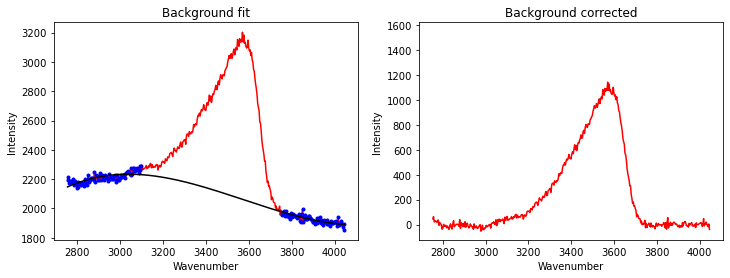

In [52]:


lower_range_water=[2750, 3100] # MAtlab code uses 0-200, 
upper_range_water=[3750, 4100] #1240-1500
sigma_water=5
exclude_range1_water=None
exclude_range2_water=None
N_poly_water=3
plot_figure=True
fit_water='poly'

Water=MI_Mix_Best

# These bits of code trim out the excluded regions if relevant
if exclude_range1_water is not None and exclude_range2_water is None:
    Water_old=Water.copy()
    Water=Water[(Water[:, 0]<exclude_range1_water[0])|(Water[:, 0]>exclude_range1_water[1])]
    Discard=Water_old[(Water_old[:, 0]>=exclude_range1_water[0])
                    & (Water_old[:, 0]<=exclude_range1_water[1])]


if exclude_range2 is not None and exclude_range1 is None:
    Water_old=Water.copy()
    Water=Water[(Water[:, 0]<exclude_range2_water[0])|(Water[:, 0]>exclude_range2_water[1])]

    Discard=Water_old[(Water_old[:, 0]>=exclude_range2_water[0]) 
                    & (Water_old[:, 0]<=exclude_range2_water[1])]

if exclude_range1 is not None and exclude_range2 is not None:
    Water_old=Water.copy()
    Water=Water[
    ((Water[:, 0]<exclude_range1_water[0])|(Water[:, 0]>exclude_range1_water[1]))
    &
    ((Water[:, 0]<exclude_range2_water[0])|(Water[:, 0]>exclude_range2_water[1]))
    ]

    Discard=Water_old[
    ((Water_old[:, 0]>=exclude_range1_water[0]) & (Water_old[:, 0]<=exclude_range1_water[1]))
    |
    ((Water_old[:, 0]>=exclude_range2_water[0]) & (Water_old[:, 0]<=exclude_range2_water[1]))
    ]


# Now we calculate the edge of the baseline
lower_0baseline_water=lower_range_water[0]
upper_0baseline_water=lower_range_water[1]
lower_1baseline_water=upper_range_water[0]
upper_1baseline_water=upper_range_water[1]

# Bit that is actually peak, not baseline
span=[upper_0baseline_water, lower_1baseline_water]

# lower_2baseline=1320
# upper_2baseline=1330

# Trim for entire range
Water_short=Water[ (Water[:,0]>lower_0baseline_water) 
              & (Water[:,0]<upper_1baseline_water) ]

# Get actual baseline
Baseline_with_outl_water=Water_short[
((Water_short[:, 0]<upper_0baseline_water) &(Water_short[:, 0]>lower_0baseline_water))
     |
((Water_short[:, 0]<upper_1baseline_water) &(Water_short[:, 0]>lower_1baseline_water))]

# Calculates the median for the baseline and the standard deviation
Median_Baseline_water=np.mean(Baseline_with_outl_water[:, 1])
Std_Baseline_water=np.std(Baseline_with_outl_water[:, 1])

# Removes any points in the baseline outside of 2 sigma (helps remove cosmic rays etc).
Baseline_water=Baseline_with_outl_water[
(Baseline_with_outl_water[:, 1]<Median_Baseline_water+sigma_water*Std_Baseline_water)
                            &
(Baseline_with_outl_water[:, 1]>Median_Baseline_water-sigma_water*Std_Baseline_water)
                           ]


#Baseline=Baseline_with_outl


if fit_water == 'poly':
    # Fits a polynomial to the baseline of degree
    Pf_baseline_water = np.poly1d(np.polyfit(Baseline_water[:, 0], Baseline_water[:, 1], N_poly_water))
    Py_base_water =Pf_baseline_water(Water_short[:, 0])
    


    Baseline_ysub_water=Pf_baseline_water(Water_short[:, 0])

    
if  fit_water == 'spline':
    from scipy.interpolate import CubicSpline
    mix_spline_water = CubicSpline(Baseline_water[:, 0], Baseline_water[:, 1],  
                            extrapolate=True)
    
    Baseline_ysub_water=mix_spline_water(Water_short[:, 0]) 
    
    
    N_poly_water='Spline'
    
Baseline_x_water=Water_short[:, 0]
y_corr_water= Water_short[:, 1]- Baseline_ysub_water

x_water=Baseline_water[:, 0]

 # Plotting what its doing
if plot_figure is True:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.set_title('Background fit')
    ax1.plot(Water_short[:, 0], Water_short[:, 1], '-r')

    ax1.plot(Baseline_water[:, 0], Baseline_water[:, 1], '.b')
    ax1.plot(Water_short[:, 0], Baseline_ysub_water, '-k')
    xdat_water=(Water_short[:, 0])
    ydat_water=y_corr_water

    ax1.set_ylabel('Intensity')
    ax2.set_ylabel('Intensity')
    ax2.set_xlabel('Wavenumber')



    ax2.set_title('Background corrected')
    ax2.plot(xdat_water, y_corr_water, '-r')
    height_p=np.max(Water_short[:, 1])-np.min(Water_short[:, 1])
    ax2.set_ylim([np.min(y_corr), 1.2*height_p ])
    ax1.set_xlabel('Wavenumber')


from numpy import trapz
from scipy.integrate import simps
xspace_water=xdat_water[1]-xdat_water[0]
area_trap = trapz(y_corr_water, dx=xspace_water)
area_simps = simps(y_corr_water, dx=xspace_water)



df_water=pd.DataFrame(data={'Water_LHS_Back1':lower_range_water[0],
                      'Water_LHS_Back2':lower_range_water[1],
                      'Water_RHS_Back1':upper_range_water[0],
                      'Water_RHS_Back2':upper_range_water[1],
                      'Water_N_Poly': N_poly_water,
                      'Water_Trapezoid_Area':area_trap,
                      'Water_Simpson_Area': area_simps}, index=[0])
df_water

In [58]:
Combo_Area=pd.concat([df_sil, df_water], axis=1)

Combo_Area.insert(0, 'Trap_H2O_Sil', 
                  Combo_Area['Water_Trapezoid_Area']/Combo_Area['Sil_Trapezoid_Area'])
Combo_Area.insert(1, 'Simp_H2O_Sil',
                  Combo_Area['Water_Simpson_Area']/Combo_Area['Sil_Simpson_Area'])
Combo_Area

,Trap_H2O_Sil,Simp_H2O_Sil,Sil_LHS_Back1,Sil_LHS_Back2,Sil_RHS_Back1,Sil_RHS_Back2,Sil_N_Poly,Sil_Trapezoid_Area,Sil_Simpson_Area,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly,Water_Trapezoid_Area,Water_Simpson_Area
0,0.245038,0.244733,200,300,1240,1500,2,1.359518e+06,1.361283e+06,2750,3100,3750,4100,3,333132.929609,333151.253365


# Two peak fit

In [24]:
peak1_gauss=400
amplitude_1=1000
peak_pos_gauss_sub=1000

# Fitting 1st Gaussian
prefix_1='gauss1'
model = GaussianModel(prefix=prefix_1)
params = model.make_params()

params[prefix_1 + 'amplitude'].set(amplitude_1, min=0)
params[prefix_1 + 'center'].set(peak1_gauss, min=peak1_gauss-200,
                            max=peak1_gauss+200)

params[prefix_1 + 'fwhm'].set(10, min=2,
                            max=3)

# Fitting second gaussian
amplitude_2=3000


peak, pars = add_peak_gauss(prefix='g2_', center=peak_pos_gauss_sub,
min_cent=peak_pos_gauss_sub-200, max_cent=peak_pos_gauss_sub+200,
amplitude=amplitude_2)
model = peak+model
params.update(pars)
            
model_F=model
init = model_F.eval(params, x=xdat)
result = model_F.fit(ydat, params, x=xdat)
comps = result.eval_components()


y_best_fit=result.eval(x=xdat)






# Three peak fit

In [21]:
# peak1_gauss=400
# amplitude_1=1000
# peak_pos_gauss_sub=1000

# # Fitting 1st Gaussian
# prefix_1='gauss0'
# model = GaussianModel(prefix=prefix_1)
# params = model.make_params()

# params[prefix_1 + 'amplitude'].set(amplitude_1, min=0)
# params[prefix_1 + 'center'].set(peak1_gauss, min=peak1_gauss-200,
#                             max=peak1_gauss+200)

# params[prefix_1 + 'fwhm'].set(10, min=2,
#                             max=3)

# # Fitting second gaussian
# amplitudes=[3000.1, 500.1]


# rough_peak_positions=(1000, 700)
# for i, cen in enumerate(rough_peak_positions):
#     print(i)

#     peak, pars = add_peak_gauss(prefix='gauss' +str((i+1)), 
#                 center=cen, amplitude=amplitudes[i])
#     model = peak+model
#     params.update(pars)



            
# model_F=model
# init = model_F.eval(params, x=xdat)
# result = model_F.fit(ydat, params, x=xdat)
# comps = result.eval_components()


# y_best_fit=result.eval(x=xdat)






0
1


In [25]:
params

name,value,initial value,min,max,vary,expression
gauss1amplitude,1000.00000,None,0.00000000,inf,True,
gauss1center,400.000000,None,200.000000,600.000000,True,
gauss1sigma,1.00000000,None,0.00000000,inf,True,
gauss1fwhm,3.00000000,None,2.00000000,3.00000000,False,
gauss1height,398.942300,None,-inf,inf,False,"0.3989423*gauss1amplitude/max(1e-15, gauss1sigma)"
g2_amplitude,3000.00000,None,0.00000000,inf,True,
g2_center,1000.00000,None,800.000000,1200.00000,True,
g2_sigma,1.00000000,None,0.00000000,inf,True,
g2_fwhm,2.35482000,None,0.00000000,inf,False,2.3548200*g2_sigma
g2_height,1196.82690,None,-inf,inf,False,"0.3989423*g2_amplitude/max(1e-15, g2_sigma)"


In [26]:
amplitudes[0]

3000.1

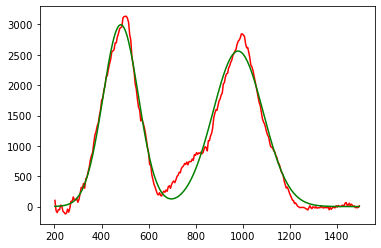

In [27]:
plt.plot(xdat, y_corr, '-r')
plt.plot(xdat, y_best_fit, '-g')

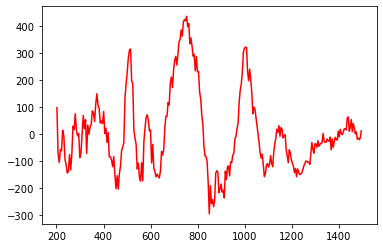

In [28]:
plt.plot(xdat, y_corr-y_best_fit, '-r')

In [ ]:
residual_2_gauss=y_corr-y_best_fit

peaks = find_peaks(y

In [40]:
y_corr

array([ 1.01415573e+02, -6.60026337e+01, -9.94322090e+01, -5.05862016e+01,
       -5.34662209e+01,  2.46348159e+01,  6.59480321e+00, -7.81310080e+01,
       -9.58297094e+01, -1.21158355e+02, -1.11219444e+02, -4.23499877e+01,
       -9.27948957e+01, -2.65579339e+01,  8.72203454e+01,  8.64083058e+01,
        1.57705653e+02,  1.10910435e+02,  1.08507995e+02,  1.37630211e+02,
        7.11365419e+01,  1.15955581e+02,  2.16227593e+02,  3.16332782e+02,
        3.05345709e+02,  3.80388735e+02,  3.01977930e+02,  4.58281110e+02,
        4.81012178e+02,  5.69602257e+02,  6.45929264e+02,  7.68153419e+02,
        8.38488443e+02,  8.90162001e+02,  1.04233688e+03,  1.17520207e+03,
        1.23177598e+03,  1.32221789e+03,  1.37447915e+03,  1.49232959e+03,
        1.59483677e+03,  1.75390058e+03,  1.78770200e+03,  1.92306397e+03,
        1.98554373e+03,  2.13576014e+03,  2.15563734e+03,  2.26229476e+03,
        2.35231942e+03,  2.42323705e+03,  2.54953109e+03,  2.56267502e+03,
        2.58348921e+03,  

In [260]:
# x=np.array([500, 600])
# y=np.array([800, 900])
# from sklearn.linear_model import LinearRegression
# lr=LinearRegression()
# Px = np.linspace(500, 600, 101)
# lr.fit(x.reshape(1, -1),y.reshape(1, -1))
# #Py=lr.predict(Px)

AttributeError: module 'numpy' has no attribute 'concencate'

In [ ]:
# Now lets mix up spectra

for i in range(0, 100):
    MI_Mix=(y_cub_MI- y_cub_Ol*i/100)/(1-i/100)
    

In [167]:
px

array([827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1206175,
       827.1206175, 827.1206175, 827.1206175, 827.1206175, 827.1

In [ ]:
# When first derivate is zero, at a turning points. 
# Second derivative - tells you if its a minimum or a maximum. Rate of change. 
# 

In [128]:
max_trough_y

-1124.9228743798164

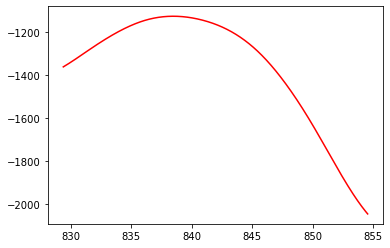

In [123]:
plt.plot(trim_x, -trim_y_cub_Ol, '-r')

In [104]:
print("Enter the items in the list")
l=y_cub_Ol
print("The given list is : ",end=" ")
print(l)
p,n,c=0,0,0
d=[]
f=[]
if l[0] > l[1]:
    d.append(l[0])
if l[0]<l[1]:
    f.append(l[0])
if l[-1]>l[-2]:
    d.append(l[-1])
if l[-1]<l[-2]:
    f.append(l[-1])
for i in range(1,len(l)):
    p=i-1
    n=i+1
    c=i
    if p>=0 and n<len(l) and c<len(l):
        if l[p]<l[c] and l[n]<l[c]:
            d.append(l[c])
        if l[p]>l[c] and l[n]>l[c]:
            f.append(l[c])
print("The peaks present in the given list is : ",d)
print("The trough present in the given list is : ",f)

Enter the items in the list
The given list is :  [804.5999756  804.60724961 804.61452229 ... 821.80942346 821.80470517
 821.7999878 ]
The peaks present in the given list is :  [1417.0194804319042, 2148.1708913258735]
The trough present in the given list is :  [804.5999756, 821.7999878, 1124.9228743798164]


In [105]:
Peak_1_x=Filt_Ol[:, 0][Filt_Ol[:, 1]==d[0]]
Peak_1_x

trough_1_x=Filt_Ol[:, 0][Filt_Ol[:, 1]==f[0]]
trough_1_x

trough_2_x=Filt_Ol[:, 0][Filt_Ol[:, 1]==f[1]]
trough_2_x

trough_3_x=Filt_Ol[:, 0][Filt_Ol[:, 1]==f[2]]
trough_3_x

array([], dtype=float64)

## Make Mass balance
Mixed_Spectra = MI * (1-X Ol) + (Ol * XOl)

Mixed_Spectra - (Ol * XOl) / (1-X Ol) = MI

In [67]:
X_Ol=0.75

MI_Ol_Sub_025=(MI- Ol*0.25)/(1-0.25)
MI_Ol_Sub_05=(MI- Ol*0.5)/(1-0.5)
MI_Ol_Sub_065=(MI- Ol*0.65)/(1-0.65)
MI_Ol_Sub_070=(MI- Ol*0.7)/(1-0.7)
MI_Ol_Sub_075=(MI- Ol*0.75)/(1-0.75)
MI_Ol_Sub_085=(MI- Ol*0.85)/(1-0.85)
MI_Ol_Sub_095=(MI- Ol*0.95)/(1-0.95)

(4000.0, 6000.0)

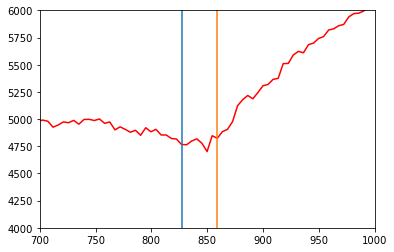

In [68]:
miny=4000
maxy=6000
plt.plot(MI_Ol_Sub_075[:, 0], MI_Ol_Sub_075[:, 1], '-r')
plt.plot([peak_pos_Ol[0], peak_pos_Ol[0]], [miny, maxy])
plt.plot([peak_pos_Ol[1], peak_pos_Ol[1]], [miny, maxy])

plt.xlim([700, 1000])
plt.ylim([miny, maxy])

(6000.0, 12000.0)

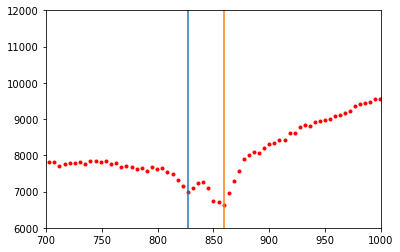

In [77]:
miny=6000
maxy=12000
plt.plot(MI_Ol_Sub_085[:, 0], MI_Ol_Sub_085[:, 1], '.r')
plt.plot([peak_pos_Ol[0], peak_pos_Ol[0]], [miny, maxy])
plt.plot([peak_pos_Ol[1], peak_pos_Ol[1]], [miny, maxy])

plt.xlim([700, 1000])
plt.ylim([miny, maxy])

(3000.0, 6000.0)

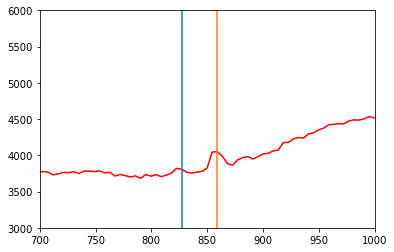

In [69]:
miny=3000
maxy=6000
plt.plot(MI_Ol_Sub_065[:, 0], MI_Ol_Sub_065[:, 1], '-r')
plt.plot([peak_pos_Ol[0], peak_pos_Ol[0]], [miny, maxy])
plt.plot([peak_pos_Ol[1], peak_pos_Ol[1]], [miny, maxy])

plt.xlim([700, 1000])
plt.ylim([miny, maxy])

(3000.0, 6000.0)

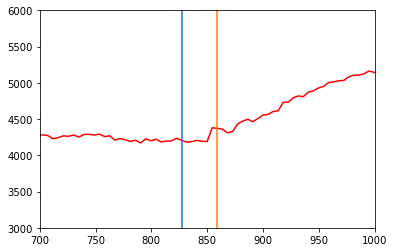

In [70]:
miny=3000
maxy=6000
plt.plot(MI_Ol_Sub_070[:, 0], MI_Ol_Sub_070[:, 1], '-r')
plt.plot([peak_pos_Ol[0], peak_pos_Ol[0]], [miny, maxy])
plt.plot([peak_pos_Ol[1], peak_pos_Ol[1]], [miny, maxy])

plt.xlim([700, 1000])
plt.ylim([miny, maxy])

(0.0, 20000.0)

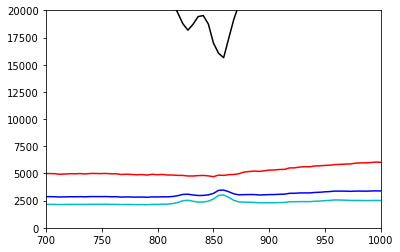

In [55]:
plt.plot(MI_Ol_Sub_025[:, 0], MI_Ol_Sub_025[:, 1], '-c')
plt.plot(MI_Ol_Sub_05[:, 0], MI_Ol_Sub_05[:, 1], '-b')
plt.plot(MI_Ol_Sub_075[:, 0], MI_Ol_Sub_075[:, 1], '-r')
# plt.plot(MI_Ol_Sub_085[:, 0], MI_Ol_Sub_085[:, 1], '-m')
plt.plot(MI_Ol_Sub_095[:, 0], MI_Ol_Sub_095[:, 1], '-k')
plt.xlim([700, 1000])
plt.ylim([0, 20000])

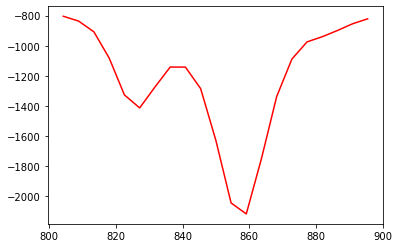

In [41]:
plt.plot(Filt_Ol[:, 0], -Filt_Ol[:, 1], '-r')

In [45]:
troughs_Ol = find_peaks(-Filt_Ol[:, 1])
# troughs_height_Ol=troughs_Ol[1]['peak_heights']
# troughs_pos_Ol = Filt_Ol[:, 0][troughs_Ol[0]]
troughs_Ol

(array([7], dtype=int64), {})

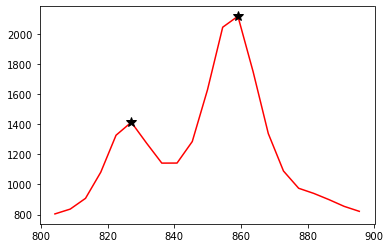

In [33]:
plt.plot(Filt_Ol[:, 0], Filt_Ol[:, 1], '-r')
plt.plot(peak_pos_Ol, peak_height_Ol, '*k', ms=10)
plt.plot(troughs_pos_Ol, troughs_height_Ol, '*g', ms=10)

(500.0, 1500.0)

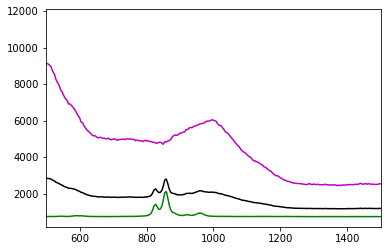

In [9]:
plt.plot(MI[:, 0], MI[:, 1], '-k')
plt.plot(Ol[:, 0], Ol[:, 1], '-g')
plt.plot(MI_Ol_Sub[:, 0], MI_Ol_Sub[:, 1], '-m')

plt.xlim([500, 1500])

## First step, find Olivine peak in MI spectra

NameError: name 'MI' is not defined

In [ ]:
plt.plot(Filt_MI[:, 0], Filt_MI[:, 1], '-k')